# Plot the impact of label budgets

### Plot the impact of label budgets with three or more baselines

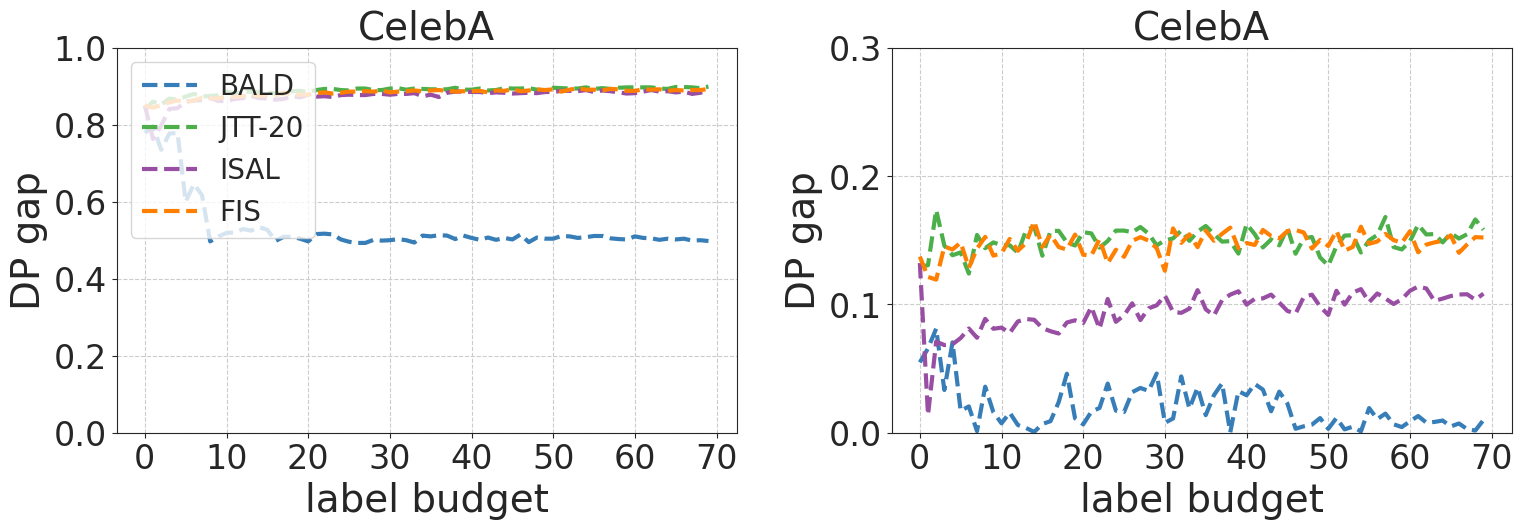

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set_style('ticks')
palette = plt.get_cmap('Set1')

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

fig, axs = plt.subplots(1, 2, figsize=(18, 5))


#############################
dataset_type = 'celeba'
runs = 0 #default random seed
fair_metric = 'dp'
sel_layers = '4'

if dataset_type == 'adult':
    dataset_tag, tol, avg_cnt =  'Adult', 0.05, 3
    sensitive_attributes = 'sex' #age
    root, file_suffix = f'./logs/fair_sampling/{dataset_type}-{sensitive_attributes}-runs{runs}/', 'default' #file-suffix represents the label budget
    gap_bounds, acc_bounds = (0.15, 0.35), (0.5, 0.8)
    step_gap, window_size = 20, 30
elif dataset_type == 'compas':
    dataset_tag, tol, avg_cnt =  'Compas', 0.05, 3
    root, file_suffix = f'./logs/fair_sampling/{dataset_type}-runs2/', 'default'
    gap_bounds, acc_bounds = (0.25, 0.35), (0.65, 0.75)
    step_gap, window_size = 20, 15
elif dataset_type == 'jigsaw':
    dataset_tag, tol, avg_cnt =  'Jigsaw', 0.05, 5
    root, file_suffix = f'./logs/fair_sampling/{dataset_type}-runs{runs}/', 'default'
    gap_bounds, acc_bounds = (0, 0.1), (0.7, 0.8)
    step_gap, window_size = 10, 6
elif dataset_type == 'celeba':
    dataset_tag, tol, avg_cnt = 'CelebA', 0.05, 3
    root, file_suffix = f'./logs/fair_sampling/{dataset_type}-runs{runs}/', 'default'
    gap_bounds, acc_bounds = (0, 0.3), (0, 1)
    step_gap, window_size = 10, 1
    binary_target = 'Smiling' # Young, Big_Nose, Attractive
    
baseline_labels_pairs = {'ERM': 's0', 
                   'Random': 's1',
                   'BALD': 's6',
                   'ISAL': 's8',
                   'JTT-20':'s7',
                   'FIS': 's5',
}
baseline_labels = ['BALD', 'JTT-20', 'ISAL'] ## illustrated  baselines
proposed_method = 'FIS' #'FIS-pred'
baseline_labels.append(proposed_method)

baseline_tags = [baseline_labels_pairs[baseline] for baseline in baseline_labels] 

if dataset_type == 'celeba':
    files = [f'{binary_target}_{baseline_tag}_{fair_metric}_{sel_layers}_{file_suffix}.log' for baseline_tag in baseline_tags]
else:
    files = [f'label_{baseline_tag}_{fair_metric}_{sel_layers}_{file_suffix}.log' for baseline_tag in baseline_tags]


def extract_data(file_path):
    with open(file_path, 'r') as file:
        data = re.findall(r'test acc: ([0-9.]+) .+ test dp gap: ([0-9.]+)', file.read())
    return [float(x[0]) for x in data], [float(x[1]) for x in data]

acc_data, gap_data = zip(*(extract_data(root + f) for f in files))
smoothed_acc = [moving_average(acc, window_size) for acc in acc_data]
smoothed_gap = [moving_average(gap, window_size) for gap in gap_data]
rounds = list(range(len(smoothed_acc[0])))

for idx, (acc, label) in enumerate(zip(smoothed_acc[1:], baseline_labels)):
    axs[0].plot(rounds, acc, color=palette(idx+1), label=label, linewidth=3, linestyle='--')
axs[0].plot(rounds, smoothed_acc[0], color=palette(4), label=proposed_method, linewidth=3, linestyle='--')
axs[0].set(title=dataset_tag, xlabel='label budget', ylabel='test accuracy', ylim=acc_bounds, xticks=np.arange(0, len(smoothed_acc[0])+10, step_gap))
axs[0].legend(loc='upper left', frameon=True, fontsize=20)
axs[0].grid(True, linestyle='--')
axs[0].tick_params(axis='both', labelsize=24)
axs[0].set_title(dataset_tag, fontsize=28)
axs[0].set_xlabel('label budget', fontsize=28)
axs[0].set_ylabel('DP gap', fontsize=28)

for idx, (gap, label) in enumerate(zip(smoothed_gap[1:], baseline_labels)):
    axs[1].plot(rounds, gap, color=palette(idx+1), label=label, linewidth=3, linestyle='--')
axs[1].plot(rounds, smoothed_gap[0], color=palette(4), label=proposed_method, linewidth=3, linestyle='--')
axs[1].set(title=dataset_tag, xlabel='label budget', ylabel='DP gap', ylim=gap_bounds, xticks=np.arange(0, len(smoothed_gap[0])+10, step_gap))
axs[1].grid(True, linestyle='--')
axs[1].tick_params(axis='both', labelsize=24)

axs[1].set_title(dataset_tag, fontsize=28)
axs[1].set_xlabel('label budget', fontsize=28)
axs[1].set_ylabel('DP gap', fontsize=28)

plt.subplots_adjust(wspace=0.25)
plt.show()

fig_path = 'figures/'
fig.savefig(f'{fig_path}{dataset_type}_impact_label_budget-mini.pdf', dpi=300, bbox_inches='tight')
